In [1]:
import time
import hydroeval as he
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb
#import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI_New

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

#new bmi_cfe is CFE open and cfe peturb

In [2]:
print(bmi_cfe_open)
#print(bmi_cfe_peturb)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI_New)
print(bmi_usgs)


<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI_New' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI_New.py'>
<module 'bmi_usgs' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\../USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
# cfe_open = bmi_cfe.BMI_CFE()
# cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
# cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

cfe_open = bmi_cfe_open.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars
#cfe_analysis = bmi_cfe_statevars_et.BMI_CFE(

enkf = Bmi_da_ENKF_forSBMI_New.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# make one bmi for all of this and options in config file

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')



initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


                time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0     5/15/2017 0:00           0.0       0.0  284.078  0.006616  6.0804   
1     5/15/2017 1:00           0.0       0.0  283.180  0.006650  6.0304   
2     5/15/2017 2:00           0.0       0.0  282.440  0.006614  5.9856   
3     5/15/2017 3:00           0.0       0.0  281.662  0.006476  5.9402   
4     5/15/2017 4:00           0.0       0.0  281.702  0.006530  6.3688   
..               ...           ...       ...      ...       ...     ...   
763  6/15/2017 19:00           0.0       0.0  295.270  0.007334 -1.1600   
764  6/15/2017 20:00           0.0       0.0  294.610  0.006788 -1.2230   
765  6/15/2017 21:00           0.0       0.0  293.624  0.006776 -1.2812   
766  6/15/2017 22:00           0.0       0.0  292.722  0.006714 -1.5682   
767  6/15/2017 23:00           0.0       0.0  291.554  0.006650 -1.8486   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -1.9670   98376.98    0.000  318.822  
1   -2.0740  

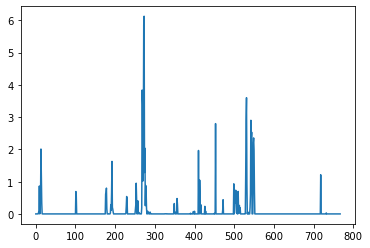

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [6]:
#Originial Version 
# basian coupling numerical error:
# the distrbutions are not well calibrated
# valibrate the model
# calibrate the pert
# set b matrix right: cov matrix in the peterbations.
# 2x2 matrix
# ground_water_storage_m 
# ground_water_storage_m <



#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []
cfe_def = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*0+6) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*0+6)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*0+6)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize. CFS 
    #obs_m = (obs * 3.281**3) #converting cfs to m3/s
    #print(obs_m)
    validity=usgs.get_value('validity')[i]
    print("-------------------------------------------------")
    print("validity",validity)

    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variables originial values from CFE Analysis to update in enkf
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    cfe_def.append(soil_reservoir_storage_deficit)
    
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    # if surface_runoff>0:
    #     print("surface_runoff",surface_runoff)
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    #print("mean", outflow_peturb_mean)
    #print("covar", outflow_peturb_covar)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    # print(usgs.get_value('validity')[0])


    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf   
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf_validity=enkf.set_value('validity',validity)
    enkf.update()


    #For plotting############################# after this
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)

    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    # print("Updated deficit",state_transition_soil_res)


#     # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    # cfe_analysis.set_value('DIRECT_RUNOFF', state_transition_runoff) 
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)

    cfe_analysis.update() #get new streamflow value based on state var change
    # set them in to pert
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    print("should be Updated deficit",cfe_updated_everything_soil_res)
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    #surface_runoff_depth_m replaced with DIRECT_RUNOFF
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    # cfe_peturbed.update()
 
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
# # want to see runoff q adjusted. vol adjusted in GIUH 
usgs.finalize()
enkf.finalize()

-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.33997484961299995
EnKF Code predicted, X Post [112.26305003]
***********under estimaiton ratio [3.21870584]
Observation BMI [166.5]
under estimaiton [94.48473935]
CFE [34.87831925]
enkf [112.26305003]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.09183353053238519
EnKF Code predicted, X Post [29.37319928]
***********over estimaiton ratio [0.42138215]
Observation BMI [161.]
new value [52.7296027]
CFE [214.18152971]
enkf [29.37319928]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.0348150564718811
EnKF Code predicted, X Post [68.37160609]
***********over estimaiton ratio [0.47626772]
Observation BMI [156.75]
new value [58.67934107]


EnKF Code predicted, X Post [12.48817637]
***********over estimaiton ratio [0.4519553]
Observation BMI [87.7]
new value [25.45299725]
CFE [58.0483979]
enkf [12.48817637]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [26.49529382]
***********over estimaiton ratio [0.51373362]
Observation BMI [87.1]
new value [27.39964841]
CFE [78.33320046]
enkf [26.49529382]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [57.10431274]
***********over estimaiton ratio [0.84221439]
Observation BMI [86.8]
new value [42.53025167]
CFE [84.12515621]
enkf [57.10431274]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------

EnKF Code predicted, X Post [29.89417926]
***********over estimaiton ratio [0.75013053]
Observation BMI [56.6]
new value [31.41918494]
CFE [58.17825317]
enkf [29.89417926]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [33.48898342]
***********over estimaiton ratio [0.55142044]
Observation BMI [56.6]
new value [28.31053589]
CFE [85.66256202]
enkf [33.48898342]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [36.95226711]
***********over estimaiton ratio [0.44252864]
Observation BMI [55.95]
new value [24.10029191]
CFE [114.56743665]
enkf [36.95226711]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning------------------------

EnKF Code predicted, X Post [14.22797951]
***********over estimaiton ratio [0.42480393]
Observation BMI [37.5]
new value [20.47090054]
CFE [65.85410836]
enkf [14.22797951]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [3.54303115]
***********over estimaiton ratio [0.23311794]
Observation BMI [37.775]
new value [10.72766395]
CFE [74.16904703]
enkf [3.54303115]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [21.79792135]
***********over estimaiton ratio [0.52163253]
Observation BMI [38.05]
new value [19.60817545]
CFE [68.14188843]
enkf [21.79792135]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning-------------------------

EnKF Code predicted, X Post [16.50586773]
***********over estimaiton ratio [0.57068086]
Observation BMI [40.7]
new value [24.76399782]
CFE [53.01206701]
enkf [16.50586773]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [11.25553902]
***********over estimaiton ratio [0.35933835]
Observation BMI [40.975]
new value [16.84563745]
CFE [69.57966878]
enkf [11.25553902]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [14.80861001]
***********over estimaiton ratio [0.39022862]
Observation BMI [41.8]
new value [16.88570251]
CFE [73.17688468]
enkf [14.80861001]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning------------------------

EnKF Code predicted, X Post [47.4565736]
***********over estimaiton ratio [0.43021256]
Observation BMI [76.7]
new value [31.98278149]
CFE [142.26380921]
enkf [47.4565736]
should be Updated deficit 0
-------------------------------------------------
validity 0.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warning validity is zero
should be Updated deficit 0.02073693050135894
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [23.37843496]
***********over estimaiton ratio [0.33639747]
Observation BMI [75.5]
new value [23.98271789]
CFE [110.36212412]
enkf [23.37843496]
should be Updated deficit 0
-------------------------------------------------
validity 0.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warnin

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:69: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


 [33.04822023]
***********over estimaiton ratio [0.49156712]
Observation BMI [64.4]
new value [37.94205548]
CFE [95.19620521]
enkf [33.04822023]
should be Updated deficit 0
-------------------------------------------------
validity 0.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warning validity is zero
should be Updated deficit 0.02073693050135894
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [40.07889737]
***********over estimaiton ratio [0.38353585]
Observation BMI [63.4]
new value [28.55424035]
CFE [140.34151539]
enkf [40.07889737]
should be Updated deficit 0
-------------------------------------------------
validity 0.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warning validity is zero
should 

EnKF Code predicted, X Post [22.93378912]
***********over estimaiton ratio [0.59018081]
Observation BMI [52.6]
new value [26.80659126]
CFE [62.15195898]
enkf [22.93378912]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [25.77874077]
***********over estimaiton ratio [0.62465338]
Observation BMI [52.6]
new value [29.74978]
CFE [63.2764455]
enkf [25.77874077]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [20.65808417]
***********over estimaiton ratio [0.54182971]
Observation BMI [52.6]
new value [28.09368214]
CFE [63.49815858]
enkf [20.65808417]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
s

new value [18.81090988]
CFE [61.16971741]
enkf [11.86537088]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [14.83402899]
***********over estimaiton ratio [0.46287058]
Observation BMI [42.9]
new value [19.42390429]
CFE [61.74756985]
enkf [14.83402899]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [23.21779459]
***********over estimaiton ratio [0.5909001]
Observation BMI [41.8]
new value [24.70804905]
CFE [62.55693458]
enkf [23.21779459]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [16.29793941]
***********over e

-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [82.83174172]
***********over estimaiton ratio [0.72877789]
Observation BMI [164.5]
new value [56.41431223]
CFE [132.52164651]
enkf [82.83174172]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [75.60682142]
***********over estimaiton ratio [1.]
Observation BMI [166.]
new value [75.42714414]
CFE [86.99491289]
enkf [75.60682142]
should be Updated deficit [0.00355847]
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [76.61880521]
***********over estimaiton ratio [0.67340819]
Observation BMI [174.]
new value [54.0842371]
CFE [134

-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [12.07909336]
***********over estimaiton ratio [0.23563338]
Observation BMI [64.525]
new value [14.08712154]
CFE [109.6033055]
enkf [12.07909336]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [31.23455279]
***********over estimaiton ratio [0.68440263]
Observation BMI [60.9]
new value [32.289694]
CFE [65.72396915]
enkf [31.23455279]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [13.06602054]
***********over estimaiton ratio [0.40346779]
Observation BMI [58.7]
new value [20.2999482]
CFE [66.45666

EnKF Code predicted, X Post [16.2184352]
***********over estimaiton ratio [0.53583449]
Observation BMI [35.5]
new value [23.00997231]
CFE [55.92312562]
enkf [16.2184352]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [19.63676905]
***********over estimaiton ratio [0.50528912]
Observation BMI [35.5]
new value [22.37496686]
CFE [66.06885476]
enkf [19.63676905]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [16.12707108]
***********over estimaiton ratio [0.34062867]
Observation BMI [34.825]
new value [15.52889498]
CFE [87.70305721]
enkf [16.12707108]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning--------------------------

Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [17.10323029]
***********over estimaiton ratio [0.66285192]
Observation BMI [27.5]
new value [26.4479472]
CFE [46.54182013]
enkf [17.10323029]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [10.99298133]
***********over estimaiton ratio [0.34385244]
Observation BMI [27.725]
new value [14.94857127]
CFE [71.94971724]
enkf [10.99298133]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
Beginning----------------------------
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [15.72084359]
***********over estimaiton ratio [0.38774373]
Observation BMI [27.95]
new value [15.81335694]
CFE [75.99851514]
enkf [15.72084359]
should be Updated deficit 0
--------

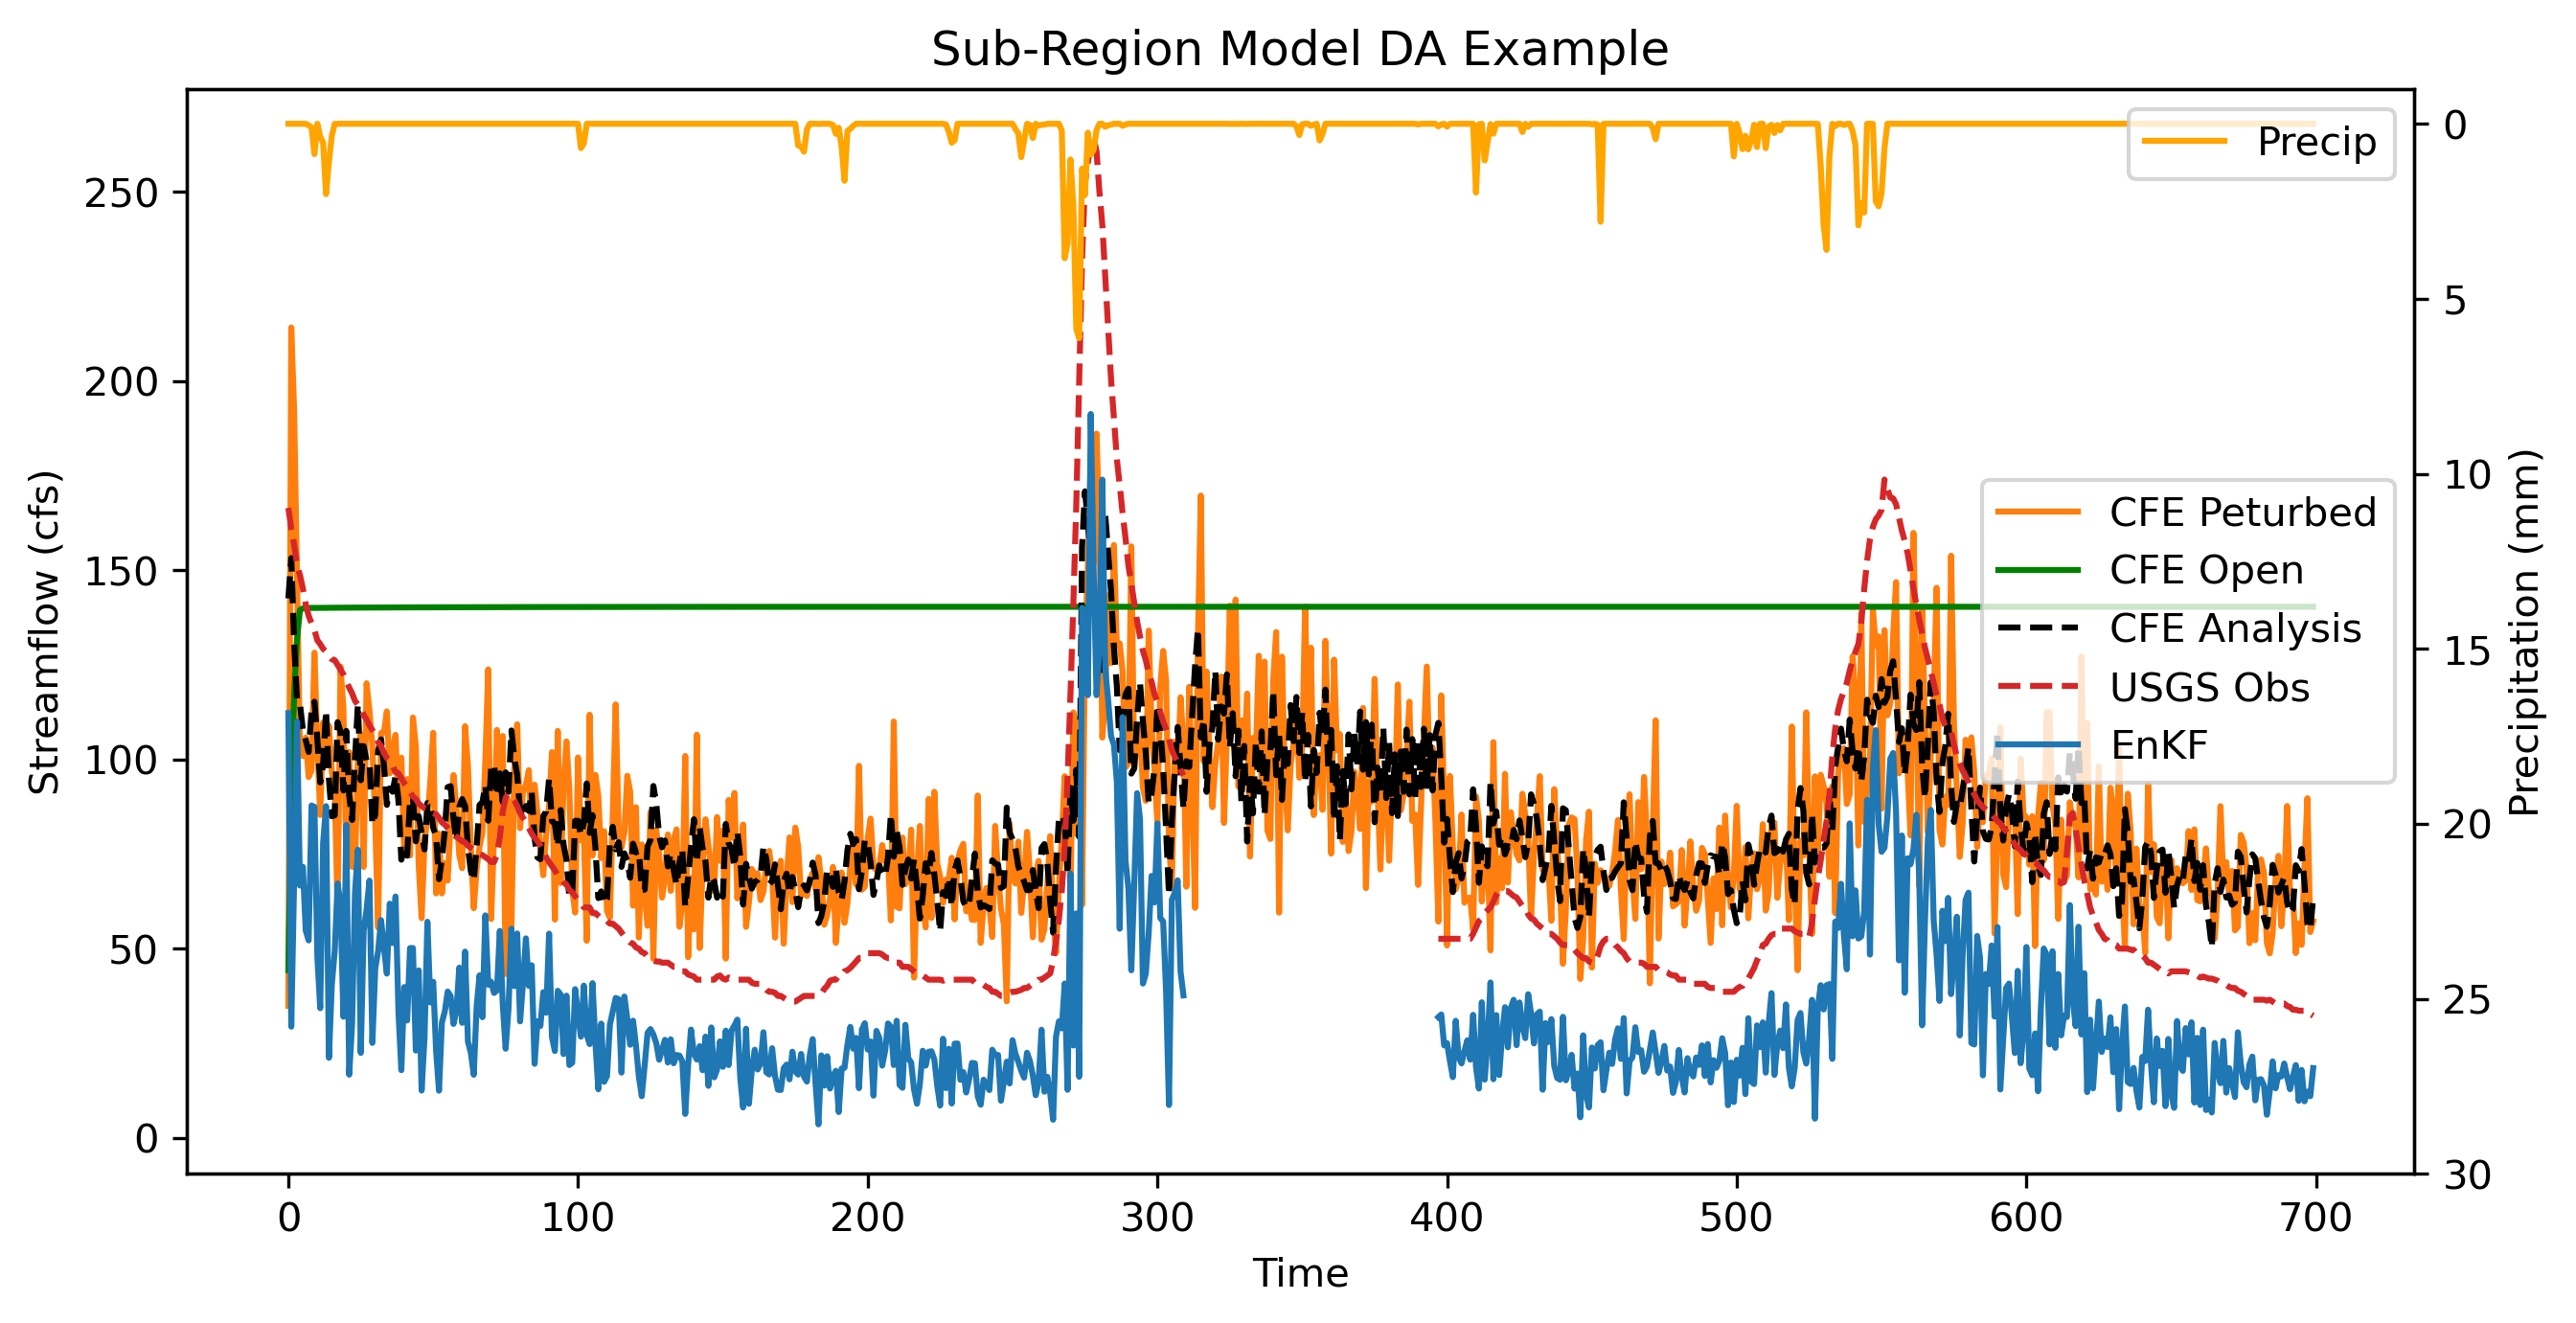

In [7]:
istart_plot=0
iend_plot=700
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(-1,30,1)
ax2.invert_yaxis()


plt.title('Sub-Region Model DA Example')
ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'black', linestyle='dashed', label = 'CFE Analysis')
ax1.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')
ax2.plot(df_forcing['APCP_surface'][istart_plot:iend_plot], color="orange", label = 'Precip')
#plt.ylabel('Streamflow (CFS)')
#plt.xlabel('Time')
ax1.legend(loc='center right')
ax2.legend(loc='upper right')
#plt.savefig("WorkingDA_7-19.png")

plt.show()


In [8]:
len(cfeOpen)

768

In [9]:
len(cfeAnalysis)

768

In [10]:
len(obs)

768

In [11]:
df=pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})

In [12]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
# nse_open=he.evaluator(he.nse,np.array(obs),np.array(cfeOpen))
# nse_analysis=he.evaluator(he.nse,obs[istart_plot:iend_plot],cfeAnalysis[istart_plot:iend_plot])
# kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, obs,cfeOpen)
# print(r_open[0])

In [14]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBIAS_open=", pbias_open[0])

r_open= -0.14637456242691618
KGE_open= -7.795165491422972
NSE_open= -404.9815494899798
PBIAS_open= 52.218658318423735


In [15]:
# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBIAS_analysis=", pbias_analysis[0])

r_analysis= 0.8580632343555668
KGE_analysis= -0.2422124920749258
NSE_analysis= -1.6551327721944702
PBIAS_analysis= 16.500666004643048


In [16]:
print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))


mean_obs= 66.93546270718221
STD_obs= 40.45261101684418
mean_open= 140.0870305259587
STD_open= 4.168444322807014
mean_analysis= 80.1628701743948
STD_analysis= 18.197340598224287
